# Recommender System

In [303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

# Familiarization

First, we will load the entire dataset and visualize it to get a first look at what we are dealing with. We have decided to visualize the given data as a matrix where on column i we can see which people the person with id i liked/disliked by checking each line and putting either a green dot if they liked the person with id j (line j), or a red dot if they disliked them.

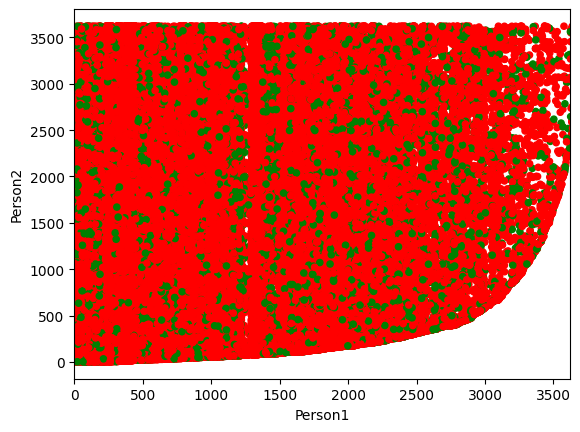

In [304]:
train_file_path = 'lab2_train.csv'

pd.set_option('display.max_rows', None)
train_data = pd.read_csv(train_file_path, delimiter=',', skipinitialspace= True)
#dropping the column related to matches as is mentioned in the assignment description
train_data = train_data.drop('is_match',axis=1)

def visualize_data(df, window=None, title=None):
    if window is None:
        start_index = 0
        end_index = train_data['user_to_id'].max()
    else:
        start_index, end_index = window
    colors = df['is_like'].map({True: 'green', False: 'red'})
    plt.scatter(df['user_from_id'], df['user_to_id'], c=colors, s=20)

    plt.xlim(start_index,end_index)

    plt.xlabel('Person1')
    plt.ylabel('Person2')

    if title is not None:
        plt.title(title)

    plt.show()

visualize_data(train_data)

On a first glance, one can easily see that users with id greater than ~2500 rate(like/dislike) a lot less than the others. There are also certain groups(intervals of columns) of people that like a lot/dislike a lot. To show a couple of examples, we will plot a few smaller window of columns that demonstrate users that mostly dislike others, and also print a list of the people who have only ever liked others, without any dislikes.

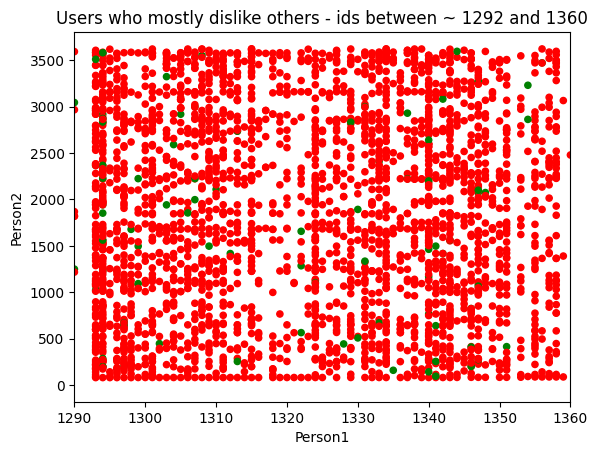

List of the ids of users who only liked others.
3604
3608
3212
3663
3674
7
2530
3607
2907
3050
3305
3385
792
3583
2773
3584
3609
2658
2341
2528
3349
3549
2926
2369
2422
3443
2157
3168
2427
3539
2066
1259
3605
2969
2781
2970
125
3677
3540
2284
820
1515
3599
2355
3586
3335
3707
3228
3347
3654
2659
1257
3497
3682
3259
2480
3380
3446
2755
3619
2503
3688
2944
3131
3197
3714
2829
1590
2269
1791
3183
1701
2725
3108
1176
2648
3176
2870
2591
2748
3177
3585
3178
2205
3601
2842
2426
674
1271
3672
3379


In [305]:
visualize_data(train_data, (1290,1360), "Users who mostly dislike others - ids between ~ 1292 and 1360")

id_counts = list(train_data[(train_data['is_like'] == True) | (train_data['is_like'] == False)]['user_from_id'].value_counts().items())
filtered_data = train_data[train_data['is_like'] == True]
like_counts = list(filtered_data['user_from_id'].value_counts().items())

all_likes_tuples = list(set(id_counts) & set(like_counts))
all_likes = [v[0] for v in all_likes_tuples]
print("List of the ids of users who only liked others.")
for id in all_likes:
    print(id)

Thus, we can observe that multiple types of people exist in our dataset. There are also examples of intervals where a lot of users did not have any type of interaction, i.e between 1250 and 1300, most users seem to not have many if any interactions at all.

# NMF-based recommender system

We will now apply our NMF algorithm on the dataset in order to then reconstruct the matrix for a proper recommender system. But first, we will have to do some preprocessing on our training dataframe. After a lot of trial and error, we have decided to:
- remove the duplicate lines, only keeping unique instances of lines
- remove rows where a user first liked a person and then disliked them, or the other way around(due to inconsistency in data) Example: user 1 liked user 2, and then disliked them afterwards. We are deleting both rows.
- remove ids of users who have never liked someone, meaning either only dislikes
- remove ids of people who have less than a certain threshold of interactions(times they appear in the dataframe) 

In our tests, the removal of such outliers has shown to improve our algorithm's accuracy and, at the same time, make a lot of sense to us in order to maintain consistency and fairness in our data.
### Preprocessing

In [306]:
#removing duplicate lines
train_data = train_data.drop_duplicates()
#removing inconsistent ids(described above)
mask = train_data.duplicated(subset=['user_from_id', 'user_to_id'],keep=False)
train_data = train_data[~mask]
#removing ids that have only disliked others
false_ids = train_data.loc[~train_data.groupby('user_from_id')['is_like'].transform('any')]['user_from_id'].to_list() #list of ids to be removed
train_data = train_data[~train_data['user_from_id'].isin(false_ids)]
#removing ids of people with a small amount of interactions
counts_list = list(train_data['user_from_id'].value_counts().items())
relevant_ids = [id for id, count in counts_list if count>=5]

train_data = train_data.reset_index(drop=True)


       user_from_id  user_to_id  is_like
0              1136        3141    False
1              2424        3174    False
2              1300        3590    False
3               800        2736    False
4               883         437    False
5               311         625    False
6                 8        1122    False
7               498         470    False
8               826          43     True
9               271        1125    False
10              491         933    False
11              337         196    False
12              422         727    False
13              877        1714    False
14             1311        1330    False
15              661        2390     True
16              590        2677    False
17             3330        2010    False
18             2636         355    False
19              375        1335    False
20             1327        3561    False
21              888        1097    False
22               90        2707    False
23              

# Distance-based recommender system

Next, we will adopt a different approach to the task of coming up with a new recommendation for a user. To build a basic intuition, we will first build a new utility matrix where both rows and columns each contain distinct user ids, and a 1 in row `i`, column `j`, would signify that user with id `j` liked user with id `i`.

Next, in order to identify two users with similar behaviour, one can directly compute the Jaccard distance between two columns and consider pairs that are very "close" to each other. To optimize issues with sparsity in data and adopt an automatic feature extraction technique, we will use min-hashing to compute a signature for each column, and then only compare these signatures.

This is the function that computes the algorithm:

In [307]:
class HashFunction:
    """
    This HashFunction class can be used to create a unique hash given a seed (useful for the reproducibility of results)
    """
    def __init__(self, seed, bigPrime = 805306457):
        self.bigPrime = bigPrime
        self.seed = seed
        random.seed(seed)
        self.alpha = random.choice(range(1,bigPrime))
        self.beta = random.choice(range(0,bigPrime))

    def compute_value(self, x, n):
        """
        Returns a hash given integers x and n.
        :param x: The value to be hashed
        :param n: Defining the range of outputs of the function [0,n-1]
        :return: The hashed value x given the seed
        """
        return ((self.alpha * x + self.beta) % self.bigPrime)  % n

def compute_signature(ids: list[set[int]], number_hash_functions = 100, hashes_seed = 32):
    """
    This function will calculate the MinHash signature matrix from our sets of ids
    using the list of hash functions (hashes)
    :param ids: The list of sets of ids -> the i-th element in this list represent the users liked by the i-th user
    :param number_hash_functions: The number of hash function we will be using
    :param hashes_seed: The seed for generating the list of seeds, used for generating the hash functions
    :return: The MinHash signature matrix for the given sets of ids, with number_hash_functions rows and as many columns as users for which have liked someone else
    """
    
    # First we need to generate the hash functions we will be using - note that the actual hash functions will be different between them, but the same in every run 
    random.seed(hashes_seed)
    hash_functions = [HashFunction(random.random()) for _ in range(number_hash_functions)]
    
    # This will be the matrix we return
    result = np.full((number_hash_functions, len(ids)), sys.maxsize)
    
    # A sorted set of the ids of the liked users (Defining the columns of the utility matrix)
    sorted_space = sorted(set().union(*ids))

    # For each liked user B
    for row_idx, row_el in enumerate(sorted_space):
        # For each liker user A
        for col_idx in range(len(ids)):
            # Did A like B?
            if row_el in ids[col_idx]:
                # Update the values of A's signature with minimal values of the hash functions, computed over the row_idx of B
                for h_idx,h in enumerate(hash_functions):
                    if result[h_idx][col_idx] > h.hashf(row_idx, len(sorted_space)):
                        result[h_idx][col_idx] = h.hashf(row_idx, len(sorted_space))
    return result

Now, in order to use the function we need decide for a list of "liker" users, sort them, then for each of them, generate a set of the id's of the users they liked. For this preprocessing step, we will also